<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_GravCont.VGGface2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : Tutorial 初級 : 転移学習チュートリアル

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


#自作データ、Early stopping

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#ukiyoeから
import matplotlib.pyplot as plt

#https://qiita.com/takanosuke/items/c22c6022a4a6d4fe2ab0
from argparse import ArgumentParser
import os
import torch
import torch.nn as nn
import numpy as np
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import *

!pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

plt.ion()   # interactive mode

     |████████████████████████████████| 1.9MB 2.8MB/s 


#Google driveのデータをマウント

In [2]:

'''
－－－－－－－－－－－－－－
アップデータするデータの構造
gravcont2.zip--data----grav
                    |--cont       
－－－－－－－－－－－－－－
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

#Advanced.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/gravcont2.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tue, 14 Jan 2020 13:22:45 +0000
Tue, 14 Jan 2020 13:22:49 +0000
data  drive  sample_data


#データセットの読み込みと正規化

In [0]:
#正規化
def prewhiten(x):
    mean = x.mean()
    std = x.std()
    std_adj = std.clamp(min=1.0/(float(x.numel())**0.5))
    y = (x - mean) / std_adj
    return y

In [11]:
#def load_dataset():
    transform = Compose([
        transforms.Resize((160,160)),
        np.float32,
        transforms.ToTensor(),
        prewhiten
    ])
    data = torchvision.datasets.ImageFolder(root='/content/data', transform=transform)
    train_size = int(len(data)* 0.8) #trainとvalidに分ける
    valid_size = len(data) - train_size
    train_data, valid_data = torch.utils.data.random_split(data, [train_size, valid_size])
    train_loader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=20, shuffle=True, num_workers=4)
    print("Load Data train:{}, valid:{}".format(str(len(train_data)), str(len(valid_data))))
    #return train_loader, valid_loader

Load Data! train:513, valid:129


In [13]:
print(train_data[1])

(tensor([[[-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         ...,
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966]],

        [[-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         ...,
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966]],

        [[-1.2966, -1.2966, -1.2966,  ..., -1.2966, -1.2966, -1.2966],
         [-1.2966, -1.2966, -1.2966,  ..., -

#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。今日解いていく問題はアリ (= ants) とハチ (= bees) を分類するモデルを訓練することです。アリとハチのためにおよそ 120 訓練画像を持ちます。各クラスのために 75 検証画像があります。通常は、スクラッチから訓練される場合、これは一般化するには非常に小さいデータセットです。私達は転移学習を使用していますので、合理的に上手く一般化することができるはずです。

このデータセットは imagenet の非常に小さなサブセットです。

In [9]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(160, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_loader = 


print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path='/content/data/hymenoptera_data/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path='/content/data/hymenoptera_data/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['cont', 'grav']
cont_train:256
grav_train:256
cont_val:65
grav_val:65
training data set_total：512
validating data set_total：130


#少数の画像を可視化する

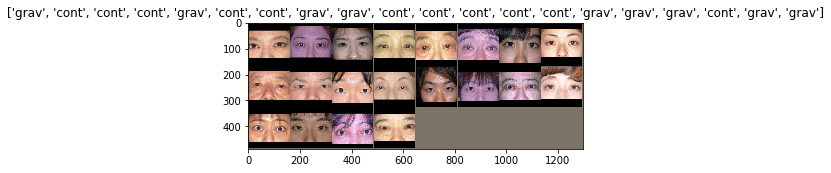

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#モデルの読み込みと調整

In [0]:
def setup_model(device):
    model = InceptionResnetV1(classify=True,pretrained='vggface2')
    for name, module in model._modules.items():
        module.requires_grad = False # 全ての層を凍結
    model.last_linear = nn.Linear(1792, 512, bias=False)
    model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
    model.logits = nn.Linear(512, 4) # 今回は4クラスに分類
    model.to(device)
    return model

In [0]:
def run(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Use Device {}".format(device))
    model = setup_model(device)
    train_loader, valid_loader = load_dataset()
    optimizer = Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(args.epoch):
        print('Starting epoch {}/{}.'.format(epoch + 1, args.epoch))
        model.train()
        train_loss = 0
        for i_batch, data in enumerate(train_loader):
            img, label = data
            img = img.to(device).float()
            label = label.to(device).long()
            pred = model(img)
            loss = criterion(pred, label)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / train_loader.__len__() * args.batch_size
        print('Train Loss: {}'.format(train_loss))

        model.eval()
        valid_loss = 0
        for i_batch, data in enumerate(valid_loader):
            img ,label = data
            img = img.to(device).float()
            label = label.to(device).long()
            pred = model(img)
            loss = criterion(pred, label)
            valid_loss += loss.item()
        valid_loss = valid_loss / valid_loader.__len__() * args.val_batch_size
        print('Validation Loss: {}'.format(valid_loss))

        if args.save_better_only and epoch > 1 and prev_loss < valid_loss:
            pass
        else:
            torch.save(model.state_dict(),
            os.path.join(args.out_weight_path,'epoch{}_validloss{:.4f}_trainloss{:.4f}.pth'.format(epoch + 1, valid_loss, train_loss)))
            prev_loss = valid_loss

#Define the Early Stopping Class

In [0]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする
ベスト・モデルをセーブする
以下で、パラメータ scheduler は torch.optim.lr_scheduler からの LR scheduler オブジェクトです。

In [0]:
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
事前訓練されたモデルをロードして最後の完全結合層をリセットします。

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.8MB/s]


#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [0]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3873 Acc: 0.8234
val Loss: 0.0930 Acc: 0.9843
Validation loss decreased (inf --> 0.092965).  Saving model ...

Epoch 1/24
----------
train Loss: 0.1304 Acc: 0.9583
val Loss: 0.0384 Acc: 1.0000
Validation loss decreased (0.092965 --> 0.038435).  Saving model ...

Epoch 2/24
----------
train Loss: 0.0959 Acc: 0.9742
val Loss: 0.0263 Acc: 1.0000
Validation loss decreased (0.038435 --> 0.026298).  Saving model ...

Epoch 3/24
----------
train Loss: 0.0745 Acc: 0.9742
val Loss: 0.0181 Acc: 1.0000
Validation loss decreased (0.026298 --> 0.018074).  Saving model ...

Epoch 4/24
----------
train Loss: 0.0510 Acc: 0.9881
val Loss: 0.0174 Acc: 0.9921
Validation loss decreased (0.018074 --> 0.017414).  Saving model ...

Epoch 5/24
----------
train Loss: 0.0483 Acc: 0.9841
val Loss: 0.0261 Acc: 0.9921
EarlyStopping counter: 1 out of 5

Epoch 6/24
----------
train Loss: 0.0370 Acc: 0.9921
val Loss: 0.0168 Acc: 0.9921
Validation loss decreased (0.017414 --> 0.016809).  Saving model ...

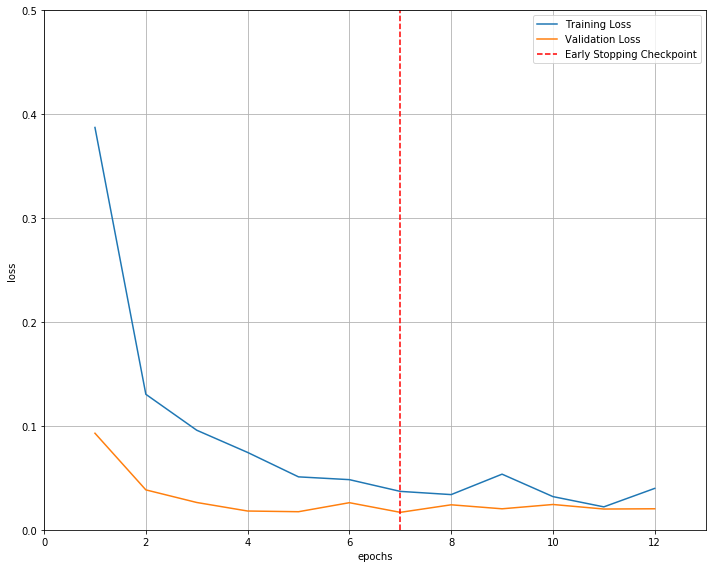

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

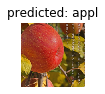

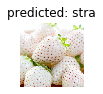

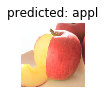

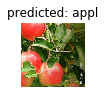

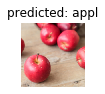

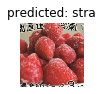

In [0]:
visualize_model(model_ft)

#固定された特徴抽出器としての ConvNet
ここで、最終層を除くネットワーク総てを凍結する必要があります。勾配が backward() で計算されないようにパラメータを凍結するために requires_grad == False を設定する必要があります。

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#訓練と評価
これは CPU 上で前のシナリオに比べておよそ半分の時間で済むでしょう。ネットワークの殆どに対して勾配が計算される必要がないためです。けれども、forward は計算される必要があります。

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0907 Acc: 0.9722
val Loss: 0.0399 Acc: 0.9921
Validation loss decreased (inf --> 0.039853).  Saving model ...

Epoch 1/24
----------
train Loss: 0.0801 Acc: 0.9802
val Loss: 0.0392 Acc: 0.9921
Validation loss decreased (0.039853 --> 0.039220).  Saving model ...

Epoch 2/24
----------
train Loss: 0.0803 Acc: 0.9762
val Loss: 0.0405 Acc: 0.9921
EarlyStopping counter: 1 out of 5

Epoch 3/24
----------
train Loss: 0.0747 Acc: 0.9861
val Loss: 0.0416 Acc: 0.9921
EarlyStopping counter: 2 out of 5

Epoch 4/24
----------
train Loss: 0.0975 Acc: 0.9742
val Loss: 0.0403 Acc: 0.9921
EarlyStopping counter: 3 out of 5

Epoch 5/24
----------
train Loss: 0.0898 Acc: 0.9643
val Loss: 0.0397 Acc: 0.9921
EarlyStopping counter: 4 out of 5

Epoch 6/24
----------
train Loss: 0.0961 Acc: 0.9643
val Loss: 0.0369 Acc: 0.9921
Validation loss decreased (0.039220 --> 0.036936).  Saving model ...

Epoch 7/24
----------
train Loss: 0.0913 Acc: 0.9643
val Loss: 0.0393 Acc: 0.9921

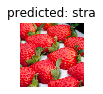

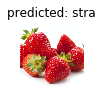

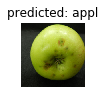

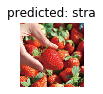

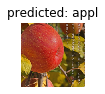

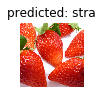

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#Visualizing the Loss and the Early Stopping Checkpoint

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(epoch_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = val_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(epoch_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

NameError: ignored

<Figure size 720x576 with 0 Axes>